# Ch 3. Modeling with Linear Regression

- topics covered:
    - simple linear regression
    - robust linear regression
    - hierarchical linear regression
    - polynomial regression
    - multiple linear regression
    - interactions
    - variable variance

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from scipy import stats
from theano import shared

## Simple linear regression

### The machine learning connection

### The core of the linear regression models

- can treat solving of linear regression multiple ways:
    - OLS has the goal of minimizing a loss function
    - Bayesian uses a probabilizistic approach

$$y \sim \mathcal{N}(\mu = \alpha + x \beta, \epsilon)$$

>  A linear regression model is an extension of the Gaussian model where the mean is not directly estimated but rather computed as a linear function of a predictor variable and some additional parameters.

- set priors for the variables in the equation

$$
\alpha \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\beta \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\epsilon \sim | \mathcal{N}(0, \sigma_\epsilon) |
$$

<img src="assets/ch03/c5c481c3-353f-4b8f-9764-d166813e263e.png" width="75%">


- an example of fitting a linear regression with fake data

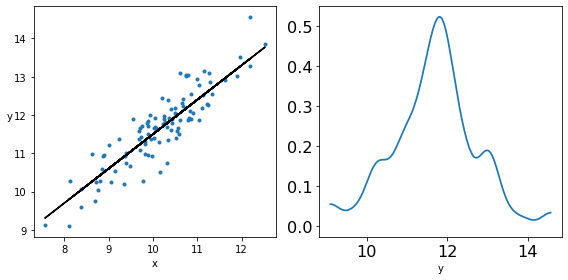

In [2]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(x, y, "C0.")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y", rotation=0)
ax[0].plot(x, y_real, "k")

az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel("y")

plt.tight_layout()
plt.show()

- I modified the priors in the model below from those provided in the book because the MCMC had too many divergences.

In [3]:
with pm.Model() as model_g:
    α = pm.Normal("α", mu=0, sd=3)
    β = pm.Normal("β", mu=1, sd=2)
    ϵ = pm.HalfCauchy("ϵ", 2)

    µ = pm.Deterministic("µ", α + β * x)
    y_pred = pm.Normal("y_pred", mu=µ, sd=ϵ, observed=y)

    trace_g = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


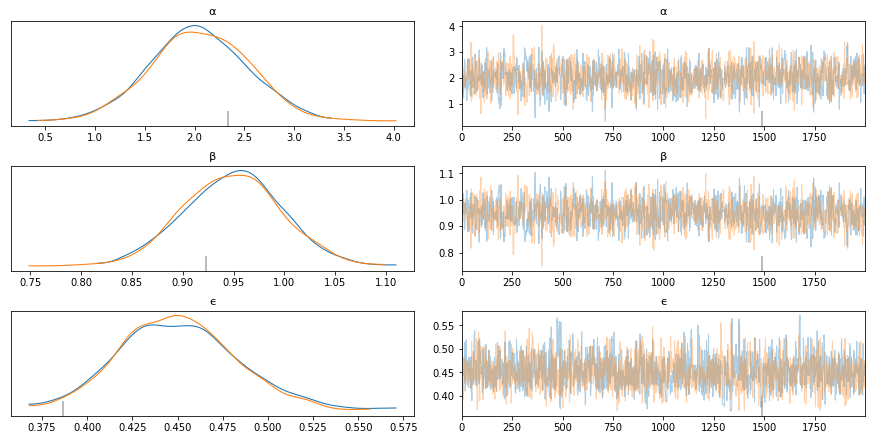

In [4]:
az_trace_g = az.from_pymc3(trace_g, model=model_g)
az.plot_trace(az_trace_g, var_names=["α", "β", "ϵ"])
plt.show()

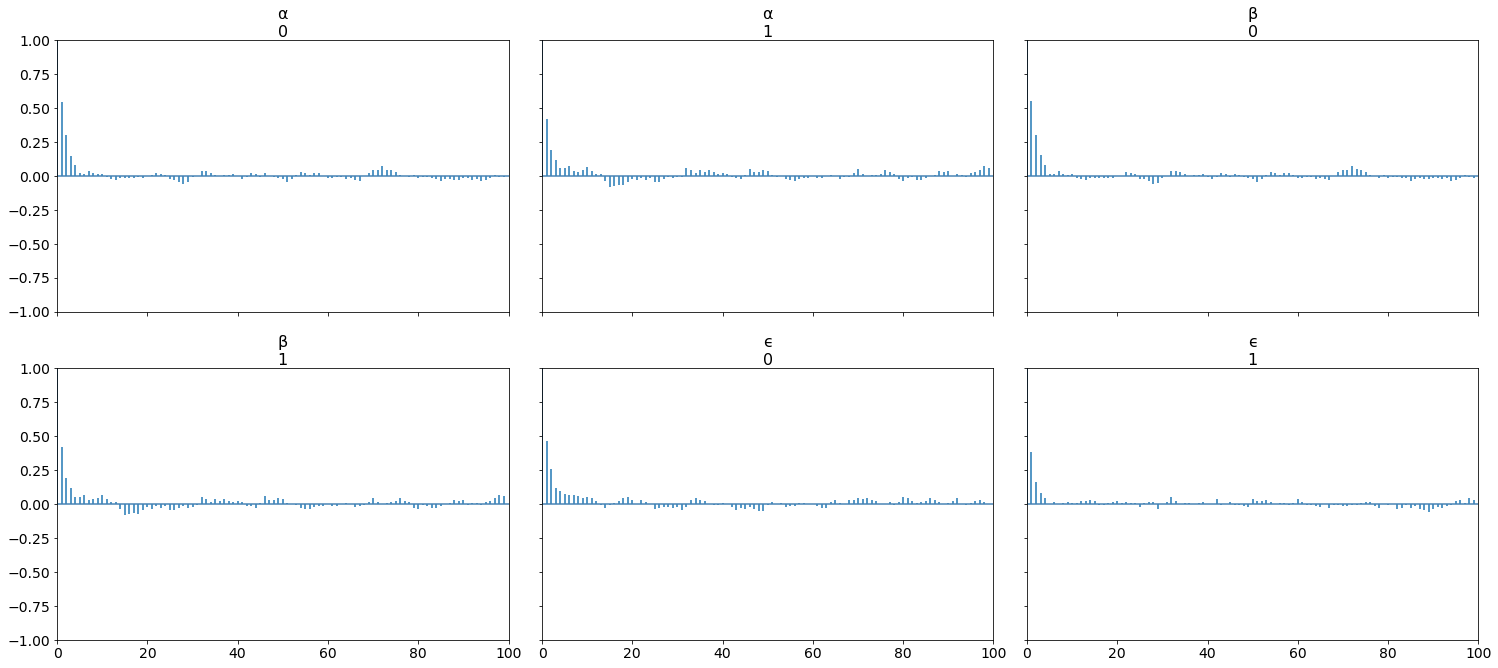

In [5]:
az.plot_autocorr(az_trace_g, var_names=["α", "β", "ϵ"])
plt.show()

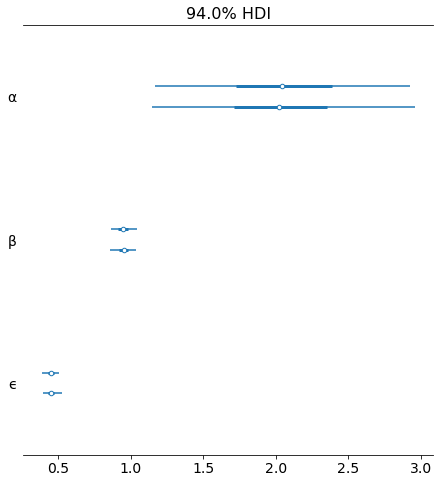

In [6]:
az.plot_forest(az_trace_g, var_names=["α", "β", "ϵ"])
plt.show()

In [7]:
with model_g:
    model_g_ppc = pm.sample_posterior_predictive(trace_g)

/Users/admin/Developer/Python/bayesian-analysis-with-python_e2/.env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


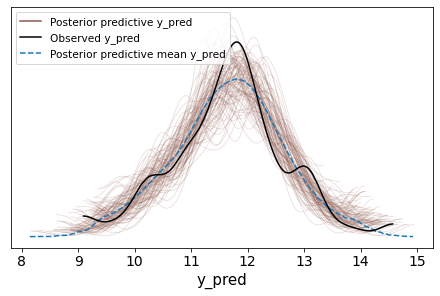

In [8]:
az.plot_ppc(
    az.from_pymc3(trace_g, posterior_predictive=model_g_ppc), num_pp_samples=100
)
plt.show()

### Linear models and high autocorrelation

- the posterior distribution of $\alpha$ and $\beta$ are highly correlated as a matter of definition
    - a change in one will result in a change in the other to compensate
    - this results in a diagonal posterior space that can be problematic for the sampling process
    - this will be discussed further in later chapters

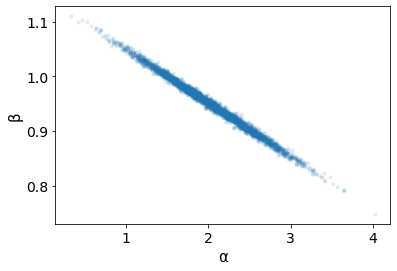

In [9]:
az.plot_pair(az_trace_g, var_names=["α", "β"], scatter_kwargs={"alpha": 0.1})
plt.show()

#### Modifying the data before running

- centering and scaling the data can help turn the diagonal posterior into a more circular form
    - this is usually better for the sampling process
- using standardized data also means that the priors of a particular model can be left alone and not adjusted for each different problem
    - otherwise would need to consider the scale of the data

### Interpreting and visualizing the posterior

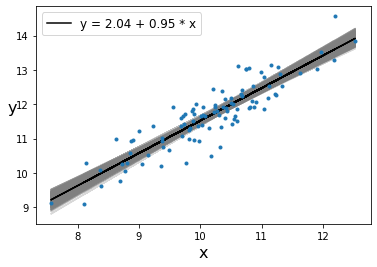

In [10]:
# Plot lines sample from the posterior.
draws = range(0, len(trace_g["α"]), 10)
plt.plot(
    x, trace_g["α"][draws] + trace_g["β"][draws] * x[:, np.newaxis], c="gray", alpha=0.3
)

# Plot line from average of posterior.
alpha_m = trace_g["α"].mean()
beta_m = trace_g["β"].mean()
plt.plot(x, alpha_m + beta_m * x, c="k", label=f"y = {alpha_m:.2f} + {beta_m:.2f} * x")

# Plot original data.
plt.plot(x, y, "C0.")

plt.xlabel("x", fontsize=16)
plt.ylabel("y", rotation=0, fontsize=16)
plt.legend(fontsize=12)
plt.show()

- plot the **highest density interval (HDI)**

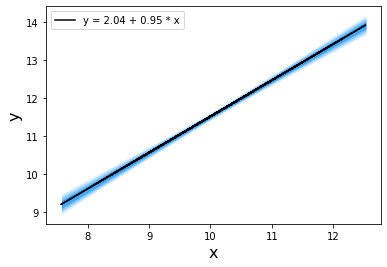

In [11]:
plt.plot(x, alpha_m + beta_m * x, c="k", label=f"y = {alpha_m:.2f} + {beta_m:.2f} * x")
for ci, c in zip([0.95, 0.89, 0.75, 0.5], ["#cfe9ff", "#99d1ff", "#52b1ff", "#058fff"]):
    az.plot_hdi(
        x=x, hdi_data=az.hdi(az_trace_g, hdi_prob=ci)["µ"], color=c, ax=plt.gca()
    )

plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.legend()
plt.show()

- also plot the HDI for $\hat{y}$
    - where the model expects to see the given percent of the data

In [12]:
ppc = pm.sample_posterior_predictive(trace_g, samples=2000, model=model_g)

/Users/admin/Developer/Python/bayesian-analysis-with-python_e2/.env/lib/python3.8/site-packages/pymc3/sampling.py:1617: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/Users/admin/Developer/Python/bayesian-analysis-with-python_e2/.env/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/admin/Developer/Python/bayesian-analysis-with-python_e2/.env/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


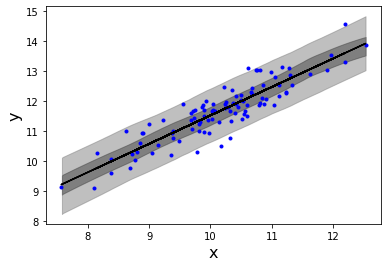

In [13]:
plt.plot(x, y, "b.")
plt.plot(x, alpha_m + beta_m * x, c="k", label=f"y = {alpha_m:.2f} + {beta_m:.2f} * x")
az.plot_hdi(
    x=x, hdi_data=az.hdi(ppc["y_pred"], hdi_prob=0.5), color="black", ax=plt.gca()
)
az.plot_hdi(
    x=x, hdi_data=az.hdi(ppc["y_pred"], hdi_prob=0.95), color="gray", ax=plt.gca()
)

plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

### Pearson correlation coefficient

#### Pearson coefficient from a multivariate Gaussian

### Robust linear regression

### Hierarchical linear regression

- create 8 related data groups
    - one group will only have 1 data point

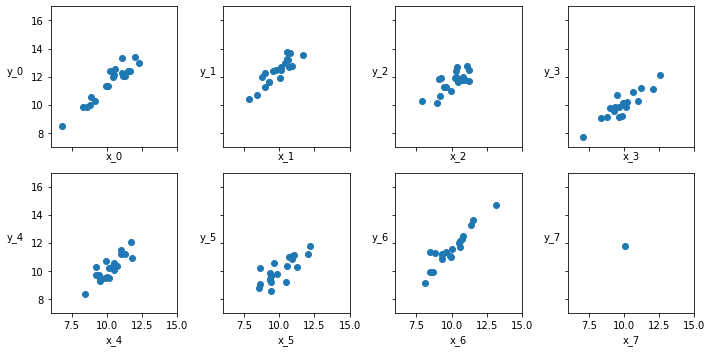

In [14]:
N = 20
M = 8
idx = np.repeat(range(M - 1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

j = 0
k = N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f"x_{i}")
    ax[i].set_ylabel(f"y_{i}", rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N

plt.tight_layout()
plt.show()

- center the data before fitting model

In [15]:
x_centered = x_m - x_m.mean()

- fit a non-hierarchical model for comparison
    - there is also a line that rescales $\alpha$ to adjust for the centering

In [16]:
with pm.Model() as unpooled_model:
    α_temp = pm.Normal("α_temp", mu=0, sd=10, shape=M)
    β = pm.Normal("β", mu=0, sd=10, shape=M)
    ϵ = pm.HalfCauchy("ϵ", 5)
    ν = pm.Exponential("ν", 1 / 30)

    y_pred = pm.StudentT(
        "y_pred", mu=α_temp[idx] + β[idx] * x_centered, sd=ϵ, nu=ν, observed=y_m
    )

    α = pm.Deterministic("α", α_temp - β * x_m.mean())

    trace_up = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α_temp]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 29 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

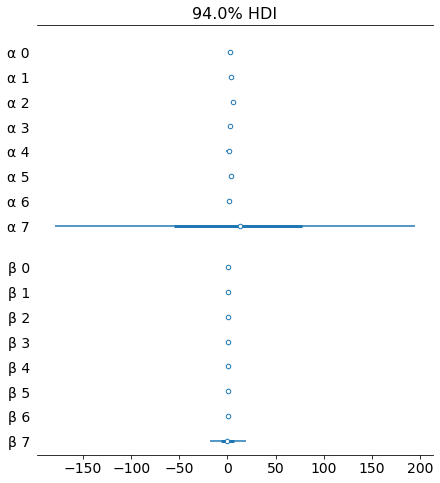

In [17]:
az_trace_up = az.from_pymc3(trace_up, model=unpooled_model)
az.plot_forest(az_trace_up, var_names=["α", "β"], combined=True)

- now fit a hierarchical model with priors on the parameters of $\alpha$ and $\beta$

<img src="assets/ch03/hierarchcical-model-diagram.png" width="75%">

In [18]:
with pm.Model() as hierarchical_model:
    # Hyper-priors
    α_µ_temp = pm.Normal("α_µ_temp", mu=0, sd=10)
    α_σ_temp = pm.HalfNormal("α_σ_temp", sd=10)
    β_µ = pm.Normal("β_µ", mu=0, sd=10)
    β_σ = pm.HalfNormal("β_σ", sd=10)

    # Priors
    α_temp = pm.Normal("α_temp", mu=α_µ_temp, sd=α_σ_temp, shape=M)
    β = pm.Normal("β", mu=β_µ, sd=β_σ, shape=M)
    ϵ = pm.HalfCauchy("ϵ", 5)
    ν = pm.Exponential("ν", 1 / 30)

    # Likelihood
    y_pred = pm.StudentT(
        "y_pred", mu=α_temp[idx] + β[idx] * x_centered, sd=ϵ, nu=ν, observed=y_m
    )

    # Transform data back into its original scale
    α = pm.Deterministic("α", α_temp - β * x_m.mean())
    α_µ = pm.Deterministic("α_µ", α_µ_temp - β_µ * x_m.mean())
    α_σ = pm.Deterministic("α_sd", α_σ_temp - β_µ * x_m.mean())

    trace_hm = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α_temp, β_σ, β_µ, α_σ_temp, α_µ_temp]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


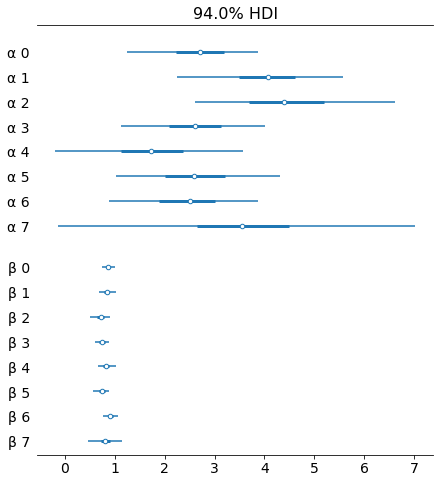

In [19]:
az_trace_hm = az.from_pymc3(trace_hm, model=hierarchical_model)
az.plot_forest(az_trace_hm, var_names=["α", "β"], combined=True)
plt.show()

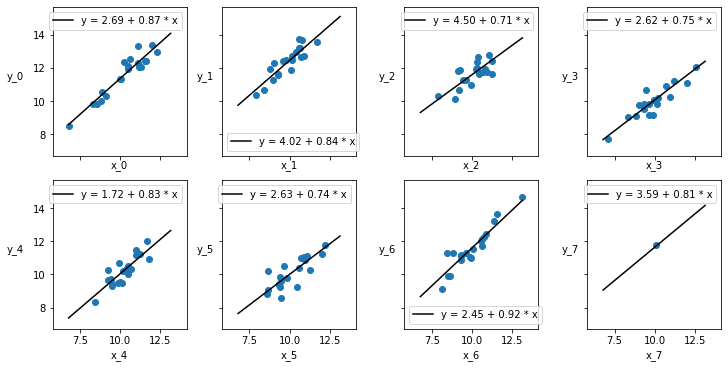

In [20]:
fix, ax = plt.subplots(
    2, 4, figsize=(10, 5), sharex=True, sharey=True, constrained_layout=True
)
ax = np.ravel(ax)

j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f"x_{i}")
    ax[i].set_ylabel(f"y_{i}", labelpad=17, rotation=0)
    alpha_m = trace_hm["α"][:, i].mean()
    beta_m = trace_hm["β"][:, i].mean()
    ax[i].plot(
        x_range,
        alpha_m + beta_m * x_range,
        c="k",
        label=f"y = {alpha_m:.2f} + {beta_m:.2f} * x",
    )
    ax[i].legend()
    plt.xlim(x_m.min() - 1, x_m.max() + 1)
    plt.ylim(y_m.min() - 1, y_m.max() + 1)
    j += N
    k += N

plt.show()

### Correlation, causation, and the messiness of life

## Polynomial regression

- example of fitting a polynomial regression

Text(0, 0.5, 'y')

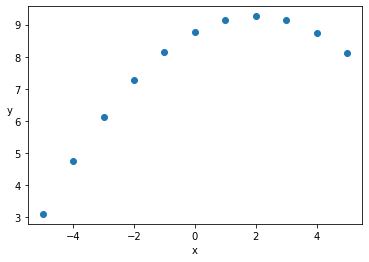

In [21]:
ans = pd.read_csv("data/anscombe.csv")
x_2 = ans[ans.group == "II"]["x"].values
y_2 = ans[ans.group == "II"]["y"].values
x_2 = x_2 - x_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel("x")
plt.ylabel("y", rotation=0)

In [22]:
with pm.Model() as model_poly:
    α = pm.Normal("α", mu=y_2.mean(), sd=1)
    β1 = pm.Normal("β1", mu=0, sd=1)
    β2 = pm.Normal("β2", mu=0, sd=1)
    ϵ = pm.HalfCauchy("ϵ", 5)

    µ = pm.Deterministic("µ", α + β1 * x_2 + β2 * (x_2 ** 2))

    y_pred = pm.Normal("y_pred", mu=µ, sd=ϵ, observed=y_2)

    trace_poly = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 25 seconds.


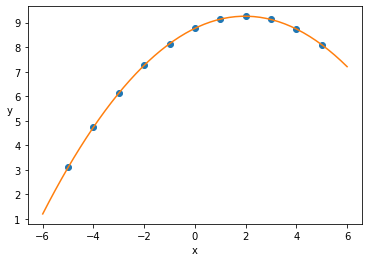

In [23]:
x_p = np.linspace(-6, 6)
y_p = (
    trace_poly["α"].mean()
    + trace_poly["β1"].mean() * x_p
    + trace_poly["β2"].mean() * x_p ** 2
)
plt.scatter(x_2, y_2)
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.plot(x_p, y_p, c="C1")
plt.show()

### Interpreting the parameters of a polynomial regression

### Polynomial regression – the ultimate model?

## Multiple linear regression

$$
\begin{align*}
\mu &= \alpha + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_m x_m \\
    &= \sum_{i=1}^{n} \beta_i x_i \\
    &= \alpha + X \beta
\end{align*}
$$

- mock data for an example

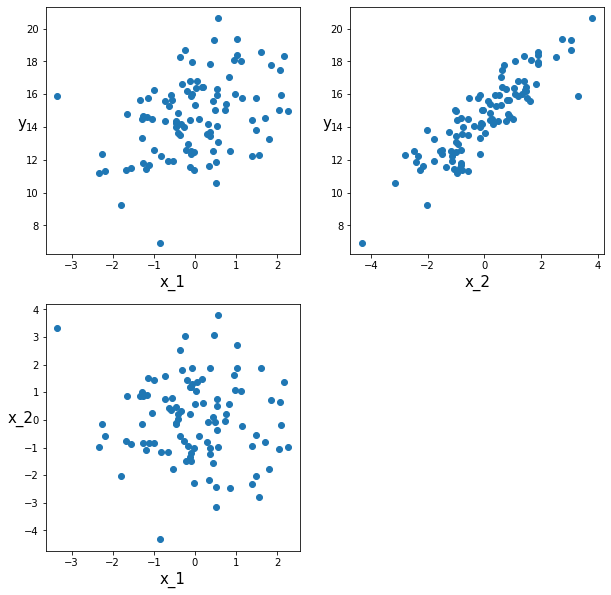

In [24]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real


def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx + 1)
        plt.scatter(x_i, y)
        plt.xlabel(f"x_{idx + 1}", fontsize=15)
        plt.ylabel("y", rotation=0, fontsize=15)
    plt.subplot(2, 2, idx + 2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f"x_{idx}", fontsize=15)
    plt.ylabel(f"x_{idx + 1}", rotation=0, fontsize=15)


scatter_plot(X_centered, y)

- the model for the multivariate model is simillar to the univariate, but with a few modifications:
    - the variable $\beta$ is a Gaussian *with shape 2*
    - define the variable $\mu$ as a dot product of $X$ and $\beta$

In [25]:
with pm.Model() as model_mlr:
    α_temp = pm.Normal("α_temp", mu=0, sd=10)
    β = pm.Normal("β", mu=0, sd=1, shape=2)  # `shape=2` because 2 slopes
    ϵ = pm.HalfCauchy("ϵ", 5)

    µ = α_temp + pm.math.dot(X_centered, β)

    α = pm.Deterministic("α", α_temp - pm.math.dot(X_mean, β))

    y_pred = pm.Normal("y_pred", mu=µ, sd=ϵ, observed=y)

    trace_mlr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α_temp]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 19 seconds.


In [26]:
az_trace_mlr = az.from_pymc3(trace=trace_mlr, model=model_mlr)
var_names = ["α", "β", "ϵ"]
az.summary(az_trace_mlr, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α[0],1.857,0.449,0.985,2.654,0.006,0.004,5521.0,5058.0,5493.0,2968.0,1.0
β[0],0.968,0.044,0.890,1.052,0.001,0.000,5515.0,5515.0,5470.0,3076.0,1.0
β[1],1.470,0.032,1.412,1.531,0.000,0.000,5716.0,5703.0,5709.0,3379.0,1.0
ϵ,0.474,0.036,0.408,0.541,0.000,0.000,5665.0,5585.0,5675.0,3004.0,1.0


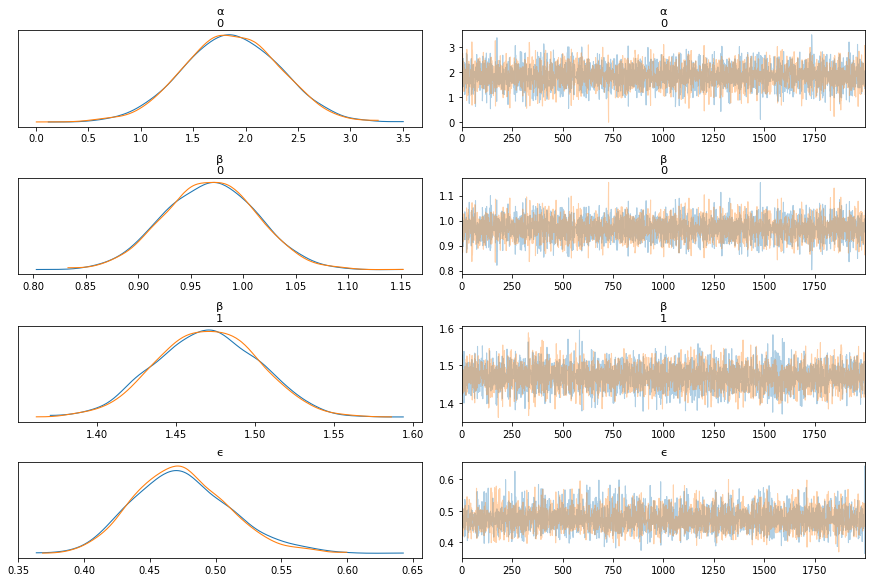

In [27]:
az.plot_trace(az_trace_mlr, var_names=var_names)
plt.show()

### Confounding variables and redundant variables

### Multicolinearity or when the correlation is too high

### Masking effect variables

### Adding interactions

## Variable variance

- can use a linear model to model the variance of the data when the assumption of constant variance is not appropriate
- example: WHO data in baby length as a measure of age

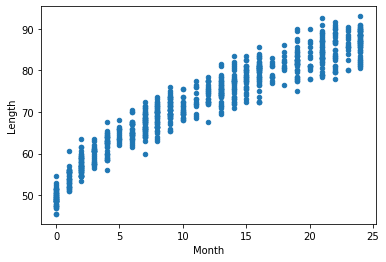

In [28]:
data = pd.read_csv("data/babies.csv").rename({"Lenght": "Length"}, axis=1)
data.plot.scatter("Month", "Length")
plt.show()

- three new elements to the previous linear models:
    - $\epsilon$ as a linear function of $x$ with a parameters $\gamma$ and $\delta$ as analogs of $\alpha$ and $\beta$
    - the linear model for the mean is a function of $\sqrt{x}$ because the data has a curve
    - include a shared variance `x_shared` to change the values of $x$ without needing to refit the model (continue further in the notes to see why this is useful)
        - this does not work as the author intended, so just ignore it for now

In [29]:
with pm.Model() as model_vv:
    α = pm.Normal("α", sd=10)
    β = pm.Normal("β", sd=10)
    γ = pm.HalfNormal("γ", sd=10)
    ẟ = pm.HalfNormal("ẟ", sd=10)

    x_shared = shared(data.Month.values * 1.0)

    µ = pm.Deterministic("µ", α + β * (x_shared ** 0.5))
    ϵ = pm.Deterministic("ϵ", γ + ẟ * x_shared)

    y_pred = pm.Normal("y_pred", mu=µ, sd=ϵ, observed=data.Length)

    trace_vv = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ẟ, γ, β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 31 seconds.


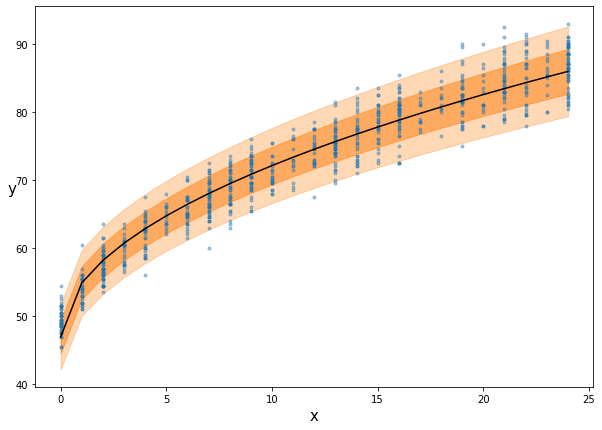

In [30]:
plt.figure(figsize=(10, 7))
plt.plot(data.Month, data.Length, "C0.", alpha=0.4)

µ_mean = trace_vv["µ"].mean(0)
ϵ_mean = trace_vv["ϵ"].mean(0)

plt.plot(data.Month, µ_mean, c="k")

plt.fill_between(
    data.Month, µ_mean + 1 * ϵ_mean, µ_mean - 1 * ϵ_mean, alpha=0.5, color="C1"
)
plt.fill_between(
    data.Month, µ_mean + 2 * ϵ_mean, µ_mean - 2 * ϵ_mean, alpha=0.3, color="C1"
)

plt.xlabel("x", fontsize=15)
plt.ylabel("y", fontsize=15, rotation=0)

plt.show()

- want to get a prediction from the model on input it has never seen

In [31]:
x_shared.get_value().shape

(800,)

In [32]:
x_shared.set_value([0.5])
ppc = pm.sample_posterior_predictive(trace=trace_vv, samples=2000, model=model_vv)
y_ppc = ppc["y_pred"][:, 0]
y_ppc

array([54.3918917 , 53.89657183, 53.57404815, ..., 57.92876611,
       52.80837472, 51.47306132])

In [33]:
ppc["y_pred"].shape

(2000, 800)